# Machine Learning Project
## Yuanyuan Ge | Alayna C. Myrick | Calvin Wu


• reviewerID -ID of the reviewer, e.g. A2SUAM1J3GNN3B 
• asin -ID of the product, e.g. 0000013714 
• reviewerName -name of the reviewer 
• helpful -helpfulness rating of the review, e.g. 2 out of 3 people found the review to be helpful. The starter code’s dataframe would have 2 in the helpful_start column and 3 in the helpful_end column
• reviewText -text of the review• overall -rating of the product• summary -summary of the review
• unixReviewTime -time of the review

In [40]:
import io
import ijson
import pandas as pd
import datetime
import itertools
import collections
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import io
import ijson
import pandas as pd
from pandas import DataFrame, Series
import datetime
import re
import json
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

**Import data by using this method**

In [3]:
cols = ["reviewerID", "asin", "reviewerName", "helpful_start",
        "helpful_end", "reviewText", "overall", "summary",
        "unixReviewTime", "reviewTime"]

reviewerID = []
asin = []
reviewerName = []
helpful_start = []
helpful_end = []
reviewText = []
overall = []
summary = []
unixReviewTime = []
reviewTime = []
helpful = []

a = datetime.datetime.now()

with open('reviews_electronics.9.json', encoding="UTF-8") as json_file:
    cursor = 0
    for line_number, line in enumerate(json_file):
        #print ("Processing line", line_number + 1,"at cursor index:", cursor)
        line_as_file = io.StringIO(line)
        # Use a new parser for each line
        json_parser = ijson.parse(line_as_file)
        for prefix, type, value in json_parser:
            if (type == 'string') | (type == 'number'):
                if prefix.strip() == 'reviewerID':
                    reviewerID.append(value)
                    #print(value)
                elif prefix.strip() == 'asin':
                    asin.append(value)
                elif prefix.strip() == 'reviewerName':
                    reviewerName.append(value)
                elif prefix.strip() == 'helpful.item':
                    helpful.append(value)
                elif prefix.strip() == 'reviewText':
                    reviewText.append(value)
                elif prefix.strip() == 'overall':
                    overall.append(value)
                elif prefix.strip() == 'summary':
                    summary.append(value)
                elif prefix.strip() == 'unixReviewTime':
                    unixReviewTime.append(value)
                elif prefix.strip() == 'reviewTime':
                    reviewTime.append(value)
        cursor += len(line)

        
b = datetime.datetime.now()
       
helpful_start = [helpful[i] for i in range(len(helpful)) if i%2 == 0]
helpful_end = [helpful[i] for i in range(len(helpful)) if i%2 == 1]

df = pd.DataFrame(list(zip(reviewerID, asin, reviewerName, helpful_start, helpful_end,
                           reviewText, overall, summary, unixReviewTime, reviewTime)),
               columns =cols)
c=b-a
print(c.seconds)

38


In [5]:
df.head()

,reviewerID,asin,reviewerName,helpful_start,helpful_end,reviewText,overall,summary,unixReviewTime,reviewTime
0,AKM1MP6P0OYPR,0132793040,"Vicki Gibson ""momo4""",1,1,Corey Barker does a great job of explaining Bl...,5.0,Very thorough,1365811200,"04 13, 2013"
1,A1GPBY18FUCYJC,B004BCG9U8,jadyhall,0,0,I just received my silicone cover last week fo...,4.0,Silicone M cover,1299024000,"03 2, 2011"
2,AAV0YJFULGO7E,B004BCG9U8,Jenn,1,1,This silicone cover is great. It actually made...,5.0,CLEAR iPearl mCover High Grade Silicone Skin C...,1310083200,"07 8, 2011"
3,A17SDZYTGTN1PP,B004BCG9U8,Joanna Williams,0,0,I wanted a silicone cover to help cushion my k...,4.0,More frosted than clear,1374105600,"07 18, 2013"
4,AJK9Y4YSLOWCH,B004BCG9U8,John Caron,0,0,This is my second purchase of this product. Pr...,5.0,Butterfingers,1398470400,"04 26, 2014"


In [82]:
df.shape

(493887, 12)

**1.Treat each review as a document. Ignore misspellings. Convert all reviews to lower case. Remove stop words (use package to do this).**

**2.Handle negation: Look for the following two negations: "not" and "xxxn't" (e.g., don't, didn't etc.). Split off the "n't" part from "xxxn't" into separate words "xxx" and "not". Attach all 'not's (any normal "not" appearing in the text as well as the "n't" converted to "not") to the subsequent word, eg "not_nextword" (code this yourself).**

**3.Stem all words using Porter 1979 (use package to do this).**

In [6]:
# Define a fuction to handle negation
def negate_sequence(text):
    negation = False
    delims = "?.,!:;"
    result = []
    words = text.split()
    prev = None
    pprev = None
    for word in words:
        stripped = word.strip(delims).lower()
        negated = "not_" + stripped if negation else stripped
        result.append(negated)
        if prev:
            prev = negated

        if any(neg in word for neg in ["not", "n't"]):
            negation = not negation
        else:
            negation = False

        if any(c in word for c in delims):
            negation = False

    result = ' '.join(map(str,result)) # Remove all the not and n't
    result = re.sub(r' not ',' ', result)
    result = ''.join(map(str,result))
    result = re.sub(r"n't",' ', result)
    result = ''.join(map(str,result))
    
    return result

**4.Create frequency count table for all word stems in all reviews (this will be big). Use the most frequent 500 words to define the word vector. Create a bag-of-word vector representation for each review in electronics**

In [7]:
a = datetime.datetime.now()
review_list=df['reviewText'].tolist()
b = datetime.datetime.now()
c=b-a
print(c.seconds)

0


In [8]:
# Define a function to process the sentence
ps = PorterStemmer()

def get_review(x):
    stopWords = set(stopwords.words('english'))
    review_lower = x.lower() # Transform to lower case
    review_lower = negate_sequence(review_lower) # Handle the negation
    review_lower = review_lower.translate(str.maketrans('', '', string.punctuation)) # Remove all the punctuation
    review_lower = ''.join(map(str,review_lower))
    words = word_tokenize(review_lower) # Split the sentences into words
    wordsFiltered = []

    for w in words:
        if w not in stopWords: # Remove stop words
            w = ps.stem(w) # Use PorterStemmer to stem words
            wordsFiltered.append(w)

    return(wordsFiltered)

In [9]:
a = datetime.datetime.now()
all_words=[]
for review in review_list:
    all_words.append(get_review(review))
b = datetime.datetime.now()
c=b-a
print(c.seconds)

688


In [10]:
all_words_together = list(itertools.chain(*all_words))
# Create counter
counts = collections.Counter(all_words_together)
counts.most_common(500)

[('use', 253859),
 ('work', 217541),
 ('one', 177030),
 ('great', 174973),
 ('would', 154666),
 ('good', 142898),
 ('like', 135307),
 ('get', 135133),
 ('product', 119415),
 ('case', 115088),
 ('camera', 108940),
 ('well', 106571),
 ('time', 102540),
 ('look', 100169),
 ('price', 94312),
 ('sound', 90843),
 ('tv', 88473),
 ('cabl', 87986),
 ('qualiti', 87305),
 ('need', 85802),
 ('bought', 78767),
 ('purchas', 77233),
 ('also', 75236),
 ('batteri', 73134),
 ('screen', 72247),
 ('buy', 70757),
 ('realli', 70530),
 ('set', 67739),
 ('problem', 66536),
 ('easi', 66332),
 ('im', 65287),
 ('much', 64972),
 ('make', 64464),
 ('could', 64247),
 ('want', 64216),
 ('littl', 63893),
 ('fit', 63532),
 ('love', 62927),
 ('back', 60965),
 ('go', 59962),
 ('nice', 59613),
 ('got', 59476),
 ('better', 58904),
 ('pictur', 57837),
 ('even', 57177),
 ('thing', 57176),
 ('tri', 57026),
 ('recommend', 57003),
 ('connect', 56532),
 ('ipad', 55420),
 ('cover', 54720),
 ('still', 53651),
 ('take', 53240),
 (

In [11]:
most_common_500 = pd.DataFrame(counts.most_common(500),                             
                               columns=['words', 'count'])
most_common_500.head(15)

,words,count
0,use,253859
1,work,217541
2,one,177030
3,great,174973
4,would,154666
5,good,142898
6,like,135307
7,get,135133
8,product,119415
9,case,115088


In [12]:
wordvec=most_common_500['words'].tolist()

In [13]:
def generate_bow(review,wordvector):                    
    bag_vector = np.zeros(len(wordvector))        
    for words in review:            
        for i,word in enumerate(wordvector):                
            if words == word:                     
                bag_vector[i] += 1                            
    return np.array(bag_vector)

In [14]:
a = datetime.datetime.now()
all_bow=[]
for review in all_words:
    all_bow.append(generate_bow(review,wordvec))
b = datetime.datetime.now()
c=b-a
print(c.seconds)

480


In [16]:
all_bow_df = pd.DataFrame(all_bow,columns=most_common_500['words'],index = df['reviewerID'])
all_bow_df.head(15)

words,use,work,one,great,would,good,like,get,product,case,...,simpli,contact,notwant,satisfi,8,surpris,caus,happen,wife,ask
reviewerID,,,,,,,,,,,,,,,,,,,,,
AKM1MP6P0OYPR,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1GPBY18FUCYJC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAV0YJFULGO7E,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A17SDZYTGTN1PP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AJK9Y4YSLOWCH,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATYV9NMHGBYAO,0.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A9HWL4JB8IJOE,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1J10FPE6K91DP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2W3MSKSAPU1O8,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**5. Establish a method for measuring the distance between different reviews. Print the mutual distance between the first 100 reviews (review IDs) to screen, sorted from closest to furthest.**

In [17]:
# calculate the distance between reviews
first_100_bow=all_bow_df[:100]
euclidean_distance_df = DataFrame(euclidean_distances(first_100_bow,first_100_bow),columns = df['reviewerID'].iloc[:100],index = df['reviewerID'].iloc[:100])

# print the distance between the first 100 reviews
euclidean_distance_df

reviewerID,AKM1MP6P0OYPR,A1GPBY18FUCYJC,AAV0YJFULGO7E,A17SDZYTGTN1PP,AJK9Y4YSLOWCH,ATYV9NMHGBYAO,A9HWL4JB8IJOE,A1J10FPE6K91DP,A2W3MSKSAPU1O8,A2HG873XVOWUY1,...,A2OT4D0Z9G1GAZ,A3L7OPIFH1UMD1,A3RSB9DPCWA3ZX,AI2B1TD7IQ5SI,A2YWQ8T4JP2BNO,A19OR7BSMSPDFB,A5DKZOR1HJHGC,A2FYCK88TYTY4Y,A17AXGOFNOKL5O,A283M4QMAHLP3Z
reviewerID,,,,,,,,,,,,,,,,,,,,,
AKM1MP6P0OYPR,0.000000,5.291503,4.690416,4.898979,6.480741,10.440307,5.830952,5.196152,9.695360,4.123106,...,4.795832,5.196152,8.485281,7.280110,4.690416,5.385165,4.898979,6.324555,4.898979,4.242641
A1GPBY18FUCYJC,5.291503,0.000000,4.472136,4.898979,5.291503,9.327379,6.000000,4.358899,8.602325,4.795832,...,5.196152,5.567764,8.246211,7.681146,4.690416,5.385165,5.477226,5.291503,5.291503,4.472136
AAV0YJFULGO7E,4.690416,4.472136,0.000000,4.690416,5.830952,9.643651,6.000000,4.795832,8.246211,4.123106,...,5.000000,4.795832,8.124038,7.280110,4.472136,4.795832,5.099020,5.291503,5.099020,4.472136
A17SDZYTGTN1PP,4.898979,4.898979,4.690416,0.000000,5.830952,9.848858,6.480741,5.196152,9.273618,4.795832,...,5.000000,5.385165,8.485281,7.141428,4.472136,5.000000,5.291503,5.656854,5.099020,4.000000
AJK9Y4YSLOWCH,6.480741,5.291503,5.830952,5.830952,0.000000,9.539392,7.615773,6.082763,9.380832,6.403124,...,5.916080,6.855655,9.380832,7.810250,6.324555,6.855655,6.782330,6.782330,6.164414,5.656854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A19OR7BSMSPDFB,5.385165,5.385165,4.795832,5.000000,6.855655,10.198039,6.557439,5.477226,9.327379,5.291503,...,5.291503,5.099020,7.416198,6.782330,3.872983,0.000000,4.795832,6.082763,5.000000,4.795832
A5DKZOR1HJHGC,4.898979,5.477226,5.099020,5.291503,6.782330,10.148892,6.324555,5.567764,9.695360,4.795832,...,4.582576,5.916080,8.602325,7.280110,4.690416,4.795832,0.000000,6.000000,4.898979,4.690416
A2FYCK88TYTY4Y,6.324555,5.291503,5.291503,5.656854,6.782330,10.049876,7.615773,6.082763,9.591663,5.567764,...,6.244998,6.082763,8.717798,8.306624,5.656854,6.082763,6.000000,0.000000,6.324555,5.656854


In [18]:
dist_array = euclidean_distance_df.values
# get the unrepeated dist into a list
review_no_1=[]
review_no_2=[]
first_100_dist=[]
for i in range(1,100):
    for j in range(i+1,100):
        review_no_1.append(i)
        review_no_2.append(j)
        first_100_dist.append(dist_array[i,j])

In [19]:
first_100_dist=DataFrame({"review_no_1":review_no_1,"review_no_2":review_no_2,"distance":first_100_dist})
first_100_dist = first_100_dist.sort_values(by = 'distance', ascending = True)
first_100_dist.head()

,review_no_1,review_no_2,distance
4386,69,70,2.236068
3740,52,70,2.449490
3741,52,71,2.449490
3737,52,67,2.449490
3769,52,99,2.645751


In [20]:
first_100_dist.shape

(4851, 3)

**6. Run a PCA and graph the first two PCs for the first 100 reviews. Does your graph reflect your findings from the previous exercise?**

In [21]:
scaler = StandardScaler()
X = np.array(first_100_bow)
X_trans=scaler.fit_transform(X)

In [22]:
first_100_pca = PCA(n_components=2).fit(X_trans)
print(first_100_pca.explained_variance_ratio_)
print(first_100_pca.singular_values_)

[0.05327001 0.0474925 ]
[44.09484309 41.63503751]


In [23]:
pca_df = DataFrame(first_100_pca.transform(X_trans),columns = ['PC1', 'PC2'])

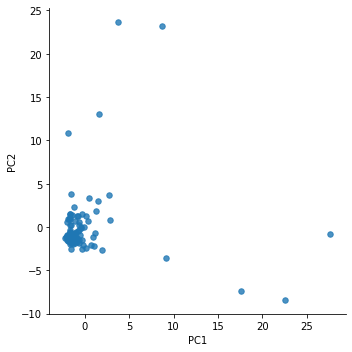

In [24]:
#plot
sns.lmplot( x="PC1", y="PC2",
  data=pca_df, 
  fit_reg=False, 
  legend=True,
  scatter_kws={"s": 30}) # specify the point size

**ANSWER:**
Most observations still cluster in this plot, which also proves that only a small part of the variance in reviews is explained by the first and second principle components (5.33% and 4.75% respectively).

**7. Is it possible to use logistic regression to predict the rating (5 levels) of a product? Why may it be advantageous to use a logistic regression to predict the 5-star rating over MNL with 5 categories?**

**ANSWER:**
Yes, because the rating are categories, and each observation has certain possibility to fall in each level, which can be predicted using logistic regression.
In contrast, MNL treats each category equally, however, here the ratings are ordinal, for which is not suitable multinomial regression.

**8. Perform a lasso logistic regression and measure the out-of-sample accuracy of your method of choice.**

In [41]:
dependent_var = df[["overall"]]

#Make the 1-5 scale within 0-1
dependent_var['overall']=np.where(df['overall'] == 5, 1, dependent_var['overall'])
dependent_var['overall']=np.where(df['overall'] == 4, 0.75, dependent_var['overall'])
dependent_var['overall']=np.where(df['overall'] == 3, 0.5, dependent_var['overall'])
dependent_var['overall']=np.where(df['overall'] == 2, 0.25, dependent_var['overall'])
dependent_var['overall']=np.where(df['overall'] == 1, 0, dependent_var['overall'])

In [42]:
#factorize
dependent_var['overall'] = dependent_var['overall'].factorize()[0]

In [44]:
independent_var = all_bow_df

In [45]:
logreg = LogisticRegression(penalty='l1', solver='liblinear')

In [46]:
def testing(target_true, target_fit):
    target_fit = np.round(target_fit)
    target_fit.astype('object')
    return accuracy_score(target_true, target_fit)
accuracy = make_scorer(testing)

accuracy_lasso_logreg = cross_val_score(logreg, independent_var, dependent_var, cv = 5, scoring = accuracy)
print(np.mean(accuracy_lasso_logreg))

0.6292572998605725


**9. --- 0.5 bonus points if the following methods are run on all reviews (across all the files). Please just continue using the reviews in your assigned file otherwise. 
--- Implement a method to aggregate reviews by product. Can you use any of the other columns to help with aggregation? Explain why or why not. Please clearly explain your method.**

Answer: We think that aggregating the reviews by product can be done by weighting the overall scores on whether or not the review started helpful. WE can then group by product number and sum the weighted overal scores. Finallyw e can divid by the weighted overalls by the summed helpful weight to find the average score per product. 

In [83]:
#read all the json files and work on Question 9 & 10

all_cols = [ "all_asin",  "helpful_start","helpful_end", "all_overall"]

all_asin = []
all_helpful=[]
helpful_start = []
helpful_end = []
all_overall = []

a = datetime.datetime.now()
print(a)

for i in range(1,17):
    print("Reading json file",i,"...")
    with open('reviews_electronics.'+str(i)+'.json', encoding="UTF-8") as json_file:
        cursor = 0
        for line_number, line in enumerate(json_file):
            #print ("Processing line", line_number + 1,"at cursor index:", cursor)
            line_as_file = io.StringIO(line)
            # Use a new parser for each line
            json_parser = ijson.parse(line_as_file)
            for prefix, type, value in json_parser:
                if (type == 'string') | (type == 'number'):
                    if prefix.strip() == 'asin':
                        all_asin.append(value)
                    elif prefix.strip() == 'helpful.item':
                        all_helpful.append(value)
                    elif prefix.strip() == 'overall':
                        all_overall.append(value)
            cursor += len(line)
    

        
b = datetime.datetime.now()
       
helpful_start = [all_helpful[i] for i in range(len(all_helpful)) if i%2 == 0]
helpful_end = [all_helpful[i] for i in range(len(all_helpful)) if i%2 == 1]

all_reviews = pd.DataFrame(list(zip(all_asin,  helpful_start, helpful_end,
                          all_overall)),columns =all_cols)
c=b-a
print("Processing used",c.seconds,"seconds")

2020-02-23 22:50:54.599350
Reading json file 1 ...
Reading json file 2 ...
Reading json file 3 ...
Reading json file 4 ...
Reading json file 5 ...
Reading json file 6 ...
Reading json file 7 ...
Reading json file 8 ...
Reading json file 9 ...
Reading json file 10 ...
Reading json file 11 ...
Reading json file 12 ...
Reading json file 13 ...
Reading json file 14 ...
Reading json file 15 ...
Reading json file 16 ...
Processing used 565 seconds


In [84]:
all_reviews.shape

(7824561, 4)

In [133]:
#calculate the helpful weight for each review and then multple by the overall score
all_reviews['helpful_weight']=(all_reviews['helpful_start']+1)
all_reviews['weighted_overall']=all_reviews['all_overall']*all_reviews['helpful_weight']
all_reviews['weighted_overall']=((all_reviews['weighted_overall']).astype(float))

In [143]:
# group by product via asin
product=all_reviews[['all_asin','helpful_weight','weighted_overall']].groupby('all_asin',as_index= False).sum()
product.head()

,all_asin,helpful_weight,weighted_overall
0,0132793040,32,160.0
1,0321732944,1,5.0
2,0439886341,9,13.0
3,0511189877,7,29.0
4,0528881469,256,792.0


In [144]:
product.shape

(476004, 3)

In [145]:
# calculate the scores by dividing the overall weighted score by the product weight
product['score']=product['weighted_overall']/product['helpful_weight']
product.head()

,all_asin,helpful_weight,weighted_overall,score
0,0132793040,32,160.0,5.000000
1,0321732944,1,5.0,5.000000
2,0439886341,9,13.0,1.444444
3,0511189877,7,29.0,4.142857
4,0528881469,256,792.0,3.093750


**10.Establish a method for measuring the distance between different products.**

In [148]:
def dist_measurement(product1,product2):
    difference=abs(float(product[product['all_asin']==product1]['score'])- float(product[product['all_asin']==product2]['score']))
    return difference

Enter two products below to test:

In [149]:
dist_measurement('B004BCG9U8','B004BDOT72')

0.3286713286713292